In [5]:
!sudo apt-get update

Hit:1 https://dl.yarnpkg.com/debian stable InRelease
Hit:2 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease       
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:6 https://packages.microsoft.com/repos/microsoft-ubuntu-focal-prod focal InRelease [3632 B]
Get:7 https://packages.microsoft.com/repos/microsoft-ubuntu-focal-prod focal/main amd64 Packages [325 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]      
Hit:9 https://packagecloud.io/github/git-lfs/ubuntu focal InRelease
Fetched 712 kB in 1s (709 kB/s)                                 
Reading package lists... Done


In [6]:
!sudo apt-get install -y libgl1-mesa-glx libglib2.0-0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
libglib2.0-0 is already the newest version (2.64.6-1~ubuntu20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [1]:
import os
!gdown 'https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK'

Downloading...
From (original): https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK
From (redirected): https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK&confirm=t&uuid=f7d6f9ee-8c1b-4af8-8d70-0a010f2f65de
To: /workspaces/Floor-Plan-Detection/model_best_val_loss_var.pkl
100%|████████████████████████████████████████| 209M/209M [00:02<00:00, 70.0MB/s]


In [2]:
# Add outer folder 
 # Adds higher directory to python modules path.
import os
# Import library
from utils.FloorplanToBlenderLib import *

# Other necessary libraries
import numpy as np

import cv2 # for image gathering

# for visualize
from PIL import Image
from IPython.display import display

In [2]:
img = cv2.imread(img_path)
display(Image.fromarray(img))

NameError: name 'img_path' is not defined

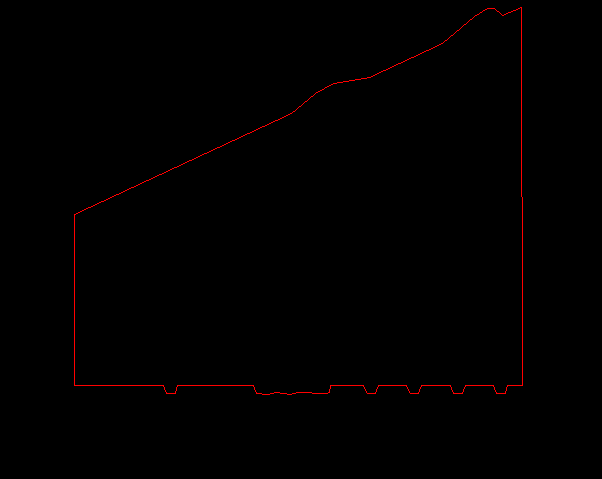

In [3]:


img_path = "Images/voorbeeld.png"
#img_path = "Images/example.png"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, img = detect.detectOuterContours(gray, blank_image, color=(255,0,0))

# Display

display(Image.fromarray(img))

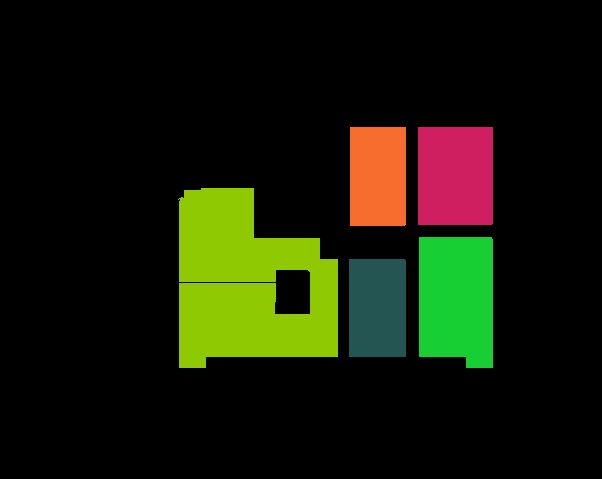

In [4]:
img = cv2.imread(img_path)

    # grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
height = 0.999

# Scale pixel value to 3d pos
scale = 100

gray = detect.wall_filter(gray)

gray = ~gray

rooms, colored_rooms = detect.find_rooms(gray.copy())

gray_rooms =  cv2.cvtColor(colored_rooms,cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
display(Image.fromarray(colored_rooms))

 #Create verts
room_count = 0
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, height)])
    room_count+= 1

# create faces
for room in verts:
    count = 0
    temp = ()
    for pos in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

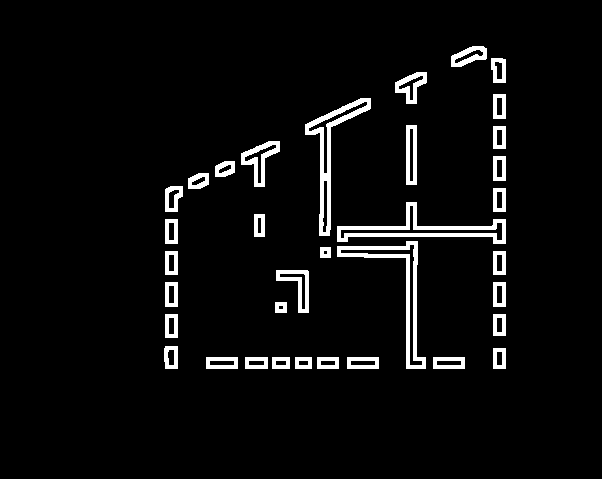

In [5]:
'''
    Generate wall data file for floorplan
    @Param img_path, path to input file
    @Param info, boolean if data should be printed
    @Return shape
    '''
from utils.FloorplanToBlenderLib import *
# Read floorplan image
img = cv2.imread(img_path)

# grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)

# detect walls
boxes, img = detect.detectPreciseBoxes(wall_img)

display(Image.fromarray(wall_img))

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
wall_height = 1

# Scale pixel value to 3d pos
scale = 100

# Convert boxes to verts and faces
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

In [6]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
import cv2 
from torch.utils.data import DataLoader

from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict,           discrete_cmap
discrete_cmap()
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath",
                "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink",
                "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()

# Create tensor for pytorch
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color channels

# Image transformation to range (-1,1)
img = 2 * (img / 255.0) - 1

# Move from (h,w,3)--->(3,h,w) as model input dimension is defined like this
img = np.moveaxis(img, -1, 0)

# Convert to pytorch, enable cuda
img = torch.tensor([img.astype(np.float32)]).cuda()
n_rooms = 12
n_icons = 11

with torch.no_grad():
    #Check if shape of image is odd or even
    size_check = np.array([img.shape[2],img.shape[3]])%2

    height = img.shape[2] - size_check[0]
    width = img.shape[3] - size_check[1]

    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(img, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)


rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers=[i for i,j in enumerate(types) if j['type']=='wall']
boxes=[]
for i,j in enumerate(polygons):
    if i in wall_polygon_numbers:
        temp=[]
        for k in j:
            temp.append(np.array([k]))
        boxes.append(np.array(temp))
        
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

/workspaces/Floor-Plan-Detection/model/hg_furukawa_original.py:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/model_1427.pth'))
/

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.